# Students:
Liav Ermias - 211684956
Ori Barel - 207813007
Ron Elyashar - 209350644

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import zipfile
import shutil
import os
import matplotlib.pyplot as plt
import math

Mount to Google Drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')
drive_root = "/content/drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define link to zip file location

In [3]:
import shutil
import zipfile

zip_drive_path = "/content/drive/My Drive/cars196_dataset.zip"

extract_path = "/content/cars_196"

if os.path.exists(zip_drive_path):
    print(f"Copying ZIP file from Drive to Colab...")
    shutil.copy(zip_drive_path, "/content/cars196_dataset.zip")
    zip_path = "/content/cars196_dataset.zip"
else:
    zip_path = "/content/cars196_dataset.zip"

if os.path.exists(zip_path):
    print(f"Extracting {zip_path} to {extract_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
else:
    print("Error: ZIP file not found in Drive or Colab. Check the path.")

Copying ZIP file from Drive to Colab...
Extracting /content/cars196_dataset.zip to /content/cars_196...
Extraction complete.


In [4]:
from glob import glob
import os

base_dir = "/content/cars_196"
all_dirs = os.listdir(base_dir)

# Find data dir
dataset_dir = None
for d in all_dirs:
    if "dataset_cars" in d:
        dataset_dir = os.path.join(base_dir, d)
        break

if dataset_dir and os.path.exists(dataset_dir):
    print(f" Found dataset directory: {dataset_dir}")
else:
    print(f" Dataset directory NOT found in: {base_dir}. Check manually.")

# Find TFRecord files
train_tfrecords = sorted(glob(os.path.join(dataset_dir, "train", "*.tfrecord*")))
test_tfrecords = sorted(glob(os.path.join(dataset_dir, "test", "*.tfrecord*")))

print(" Train TFRecord files:")
print(train_tfrecords[:3])

print("\n Test TFRecord files:")
print(test_tfrecords[:3])

if not train_tfrecords:
    print(" No train TFRecord files found.")
if not test_tfrecords:
    print(" No test TFRecord files found.")

 Found dataset directory: /content/cars_196/‏‏dataset_cars - עותק
 Train TFRecord files:
['/content/cars_196/\u200f\u200fdataset_cars - עותק/train/cars196-train.tfrecord-00000-of-00008', '/content/cars_196/\u200f\u200fdataset_cars - עותק/train/cars196-train.tfrecord-00001-of-00008', '/content/cars_196/\u200f\u200fdataset_cars - עותק/train/cars196-train.tfrecord-00002-of-00008']

 Test TFRecord files:
['/content/cars_196/\u200f\u200fdataset_cars - עותק/test/cars196-test.tfrecord-00000-of-00008', '/content/cars_196/\u200f\u200fdataset_cars - עותק/test/cars196-test.tfrecord-00001-of-00008', '/content/cars_196/\u200f\u200fdataset_cars - עותק/test/cars196-test.tfrecord-00002-of-00008']


In [5]:
import os

dummy_path = os.path.join(dataset_dir, "train", "dummy.tfrecord")
if os.path.exists(dummy_path):
    os.remove(dummy_path)
    print(f"Removed dummy file: {dummy_path}")
else:
    print("No dummy.tfrecord file found.")

Removed dummy file: /content/cars_196/‏‏dataset_cars - עותק/train/dummy.tfrecord


In [7]:
train_tfrecords = [f for f in train_tfrecords if "dummy" not in os.path.basename(f).lower()]

In [6]:
print("Filtered train TFRecords:")
for f in train_tfrecords:
    print("✅", f)

Filtered train TFRecords:
✅ /content/cars_196/‏‏dataset_cars - עותק/train/cars196-train.tfrecord-00000-of-00008
✅ /content/cars_196/‏‏dataset_cars - עותק/train/cars196-train.tfrecord-00001-of-00008
✅ /content/cars_196/‏‏dataset_cars - עותק/train/cars196-train.tfrecord-00002-of-00008
✅ /content/cars_196/‏‏dataset_cars - עותק/train/cars196-train.tfrecord-00003-of-00008
✅ /content/cars_196/‏‏dataset_cars - עותק/train/cars196-train.tfrecord-00004-of-00008
✅ /content/cars_196/‏‏dataset_cars - עותק/train/cars196-train.tfrecord-00005-of-00008
✅ /content/cars_196/‏‏dataset_cars - עותק/train/cars196-train.tfrecord-00006-of-00008
✅ /content/cars_196/‏‏dataset_cars - עותק/train/cars196-train.tfrecord-00007-of-00008
✅ /content/cars_196/‏‏dataset_cars - עותק/train/dummy.tfrecord


# Data preproccesing
Processes TFRecord files containing images and labels. It reads, decodes, augments (if using the second parse_tfrecord function), and prepares images for use in a TensorFlow deep learning model.

* parse_tfrecord() -
This function extracts images and labels from TFRecord files and processes them.

* parse_tfrecord_with_limited_augmentation() - Same but with data augmentation for load the training images

* load_tfrecord_images_and_labels_for_train() - Loads a TFRecord dataset into a list of images with augmentation.

* load_tfrecord_images_and_labels_for_test() - Loads a TFRecord dataset into a list of images and labels for visualization or processing.

In [8]:
import tensorflow as tf
import numpy as np
from PIL import Image


def parse_tfrecord(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),  # Ensure label exists
    }
    parsed_example = tf.io.parse_single_example(example, feature_description)

    # Decode image **properly**
    image = tf.io.decode_jpeg(parsed_example["image"], channels=3)
    image = tf.image.resize(image, (224, 224))  # Resize to match model input
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]

    # Convert label to one-hot encoding
    label = tf.one_hot(parsed_example["label"], depth=196)

    return image, label

def parse_tfrecord_with_limited_augmentation(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    parsed_example = tf.io.parse_single_example(example, feature_description)

    image = tf.io.decode_jpeg(parsed_example["image"], channels=3)
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]

    label = tf.one_hot(parsed_example["label"], depth=196)

    # Choose one augmentation randomly
    aug_type = tf.random.uniform(shape=[], minval=0, maxval=9, dtype=tf.int32)

    if aug_type == 0:
        image = tf.image.random_flip_left_right(image)  # Horizontal Flip
    elif aug_type == 1:
        image = tf.image.random_flip_up_down(image)  # Vertical Flip
    elif aug_type == 2:
        image = tf.image.rot90(image, k=tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32))  # Random Rotation
    elif aug_type == 3:
        image = tf.image.resize(image, size=(tf.random.uniform([], 200, 250, dtype=tf.int32),
                                             tf.random.uniform([], 200, 250, dtype=tf.int32)))  # Random Resize
        image = tf.image.resize_with_crop_or_pad(image, 224, 224)  # Crop back to 224x224
    elif aug_type == 4:
        image = tf.image.central_crop(image, central_fraction=tf.random.uniform([], 0.5, 1.0))  # Random Cropping
        image = tf.image.resize(image, (224, 224))
    elif aug_type == 5:
        # Random Shifting (translation)
        translations = tf.random.uniform([2], -20, 20, dtype=tf.int32)  # Shift range [-20,20] pixels
        transform_matrix = tf.concat([
            tf.ones([1, 1]), tf.zeros([1, 1]), tf.reshape(tf.cast(translations[0], tf.float32), [1, 1]),
            tf.zeros([1, 1]), tf.ones([1, 1]), tf.reshape(tf.cast(translations[1], tf.float32), [1, 1]),
            tf.zeros([1, 2])
        ], axis=1)
        image = tf.raw_ops.ImageProjectiveTransformV2(
            images=tf.expand_dims(image, 0),
            transforms=transform_matrix,
            interpolation="BILINEAR",
            output_shape=[224, 224]
        )[0]
    elif aug_type == 6:  # Cutout
        mask_size = 50
        max_offset = 224 - mask_size  # Ensure we don't go out of bounds
        x = tf.random.uniform([], 0, max_offset, dtype=tf.int32)
        y = tf.random.uniform([], 0, max_offset, dtype=tf.int32)

        mask = tf.ones((mask_size, mask_size, 3), dtype=tf.float32)  # Define mask
        paddings = [[y, 224 - y - mask_size], [x, 224 - x - mask_size], [0, 0]]
        cutout_mask = tf.pad(mask, paddings, constant_values=0)
        image = image * (1 - cutout_mask)  # Apply Cutout
    elif aug_type == 7:
        # Mixup (requires another example)
        second_example = tf.io.decode_jpeg(parsed_example["image"], channels=3)
        second_example = tf.image.resize(second_example, (224, 224))
        second_example = tf.cast(second_example, tf.float32) / 255.0

        mixup_lambda = tf.random.uniform([], 0.2, 0.8)
        image = image * mixup_lambda + second_example * (1 - mixup_lambda)
    elif aug_type == 8:
        # CutMix (requires another example)
        second_example = tf.io.decode_jpeg(parsed_example["image"], channels=3)
        second_example = tf.image.resize(second_example, (224, 224))
        second_example = tf.cast(second_example, tf.float32) / 255.0

        cut_x = tf.random.uniform([], 50, 150, dtype=tf.int32)
        cut_y = tf.random.uniform([], 50, 150, dtype=tf.int32)
        cut_w = tf.random.uniform([], 30, 80, dtype=tf.int32)
        cut_h = tf.random.uniform([], 30, 80, dtype=tf.int32)

        mask = tf.ones((cut_h, cut_w, 3), dtype=tf.float32)  # Define mask
        paddings = [[cut_y, 224 - cut_y - cut_h], [cut_x, 224 - cut_x - cut_w], [0, 0]]
        cutmix_mask = tf.pad(mask, paddings, constant_values=0)

        image = image * (1 - cutmix_mask) + second_example * cutmix_mask  # Apply CutMix

    return image, label


def load_tfrecord_images_and_labels_for_test(tfrecord_files):
    images, labels = [], []
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files)

    for raw_record in raw_dataset:
        try:
            image, label = parse_tfrecord(raw_record)

            # Convert image from float32 (0-1) to uint8 (0-255) for display
            image = (image.numpy() * 255).astype(np.uint8)

            images.append(Image.fromarray(image))
            labels.append(label.numpy())  # Convert Tensor to NumPy array
        except Exception as e:
            print(f"Skipped one record due to error: {e}")
            continue

    return images, labels



def load_tfrecord_images_and_labels_for_train(tfrecord_files):
    images, labels = [], []
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files)

    for raw_record in raw_dataset:
        try:
            image, label = parse_tfrecord_with_limited_augmentation(raw_record)

            # Convert image from float32 (0-1) to uint8 (0-255) for display
            image = (image.numpy() * 255).astype(np.uint8)

            images.append(Image.fromarray(image))
            labels.append(label.numpy())  # Convert Tensor to NumPy array
        except Exception as e:
            print(f"Skipped one record due to error: {e}")
            continue

    return images, labels

In [9]:
train_images, train_labels = load_tfrecord_images_and_labels_for_train(train_tfrecords)
test_images, test_labels = load_tfrecord_images_and_labels_for_test(test_tfrecords)

Skipped one record due to error: {{function_node __wrapped__Pad_device_/job:localhost/replica:0/task:0/device:GPU:0}} Paddings must be non-negative: 148 -3 [Op:Pad]
Skipped one record due to error: {{function_node __wrapped__Pad_device_/job:localhost/replica:0/task:0/device:GPU:0}} Paddings must be non-negative: 147 -2 [Op:Pad]
Skipped one record due to error: {{function_node __wrapped__Pad_device_/job:localhost/replica:0/task:0/device:GPU:0}} Paddings must be non-negative: 149 -3 [Op:Pad]
Skipped one record due to error: {{function_node __wrapped__Pad_device_/job:localhost/replica:0/task:0/device:GPU:0}} Paddings must be non-negative: 146 -1 [Op:Pad]
Skipped one record due to error: {{function_node __wrapped__Pad_device_/job:localhost/replica:0/task:0/device:GPU:0}} Paddings must be non-negative: 147 -1 [Op:Pad]


# Example of images from the dataset:

In [10]:
import matplotlib.pyplot as plt

def display_sample_images(images, labels, class_names, num_samples=9):
    plt.figure(figsize=(12, 12))
    for i in range(num_samples):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {class_names[np.argmax(labels[i])]}")
        plt.axis("off")
    plt.show()

# Define class names (assuming you have 196 classes)
class_names = [str(i) for i in range(196)]  # Modify based on your dataset

# Display train images

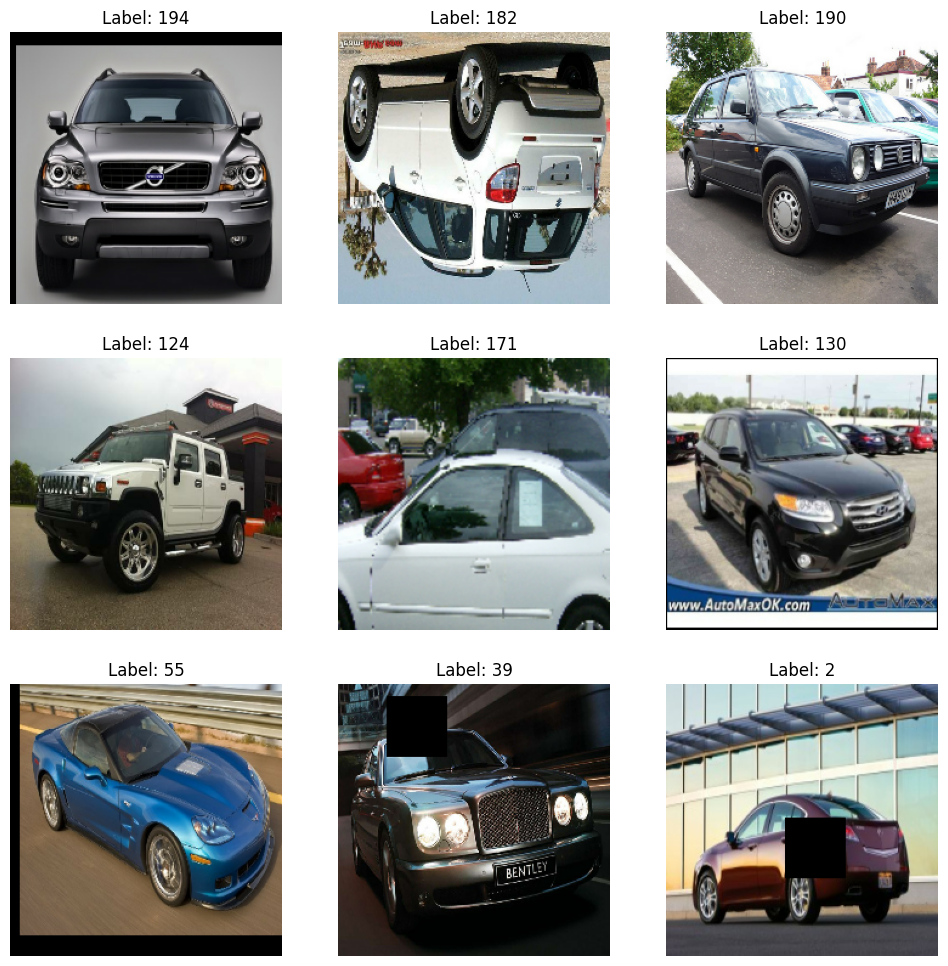

In [11]:
# Display some training images
display_sample_images(train_images, train_labels, class_names)

# Display test images:

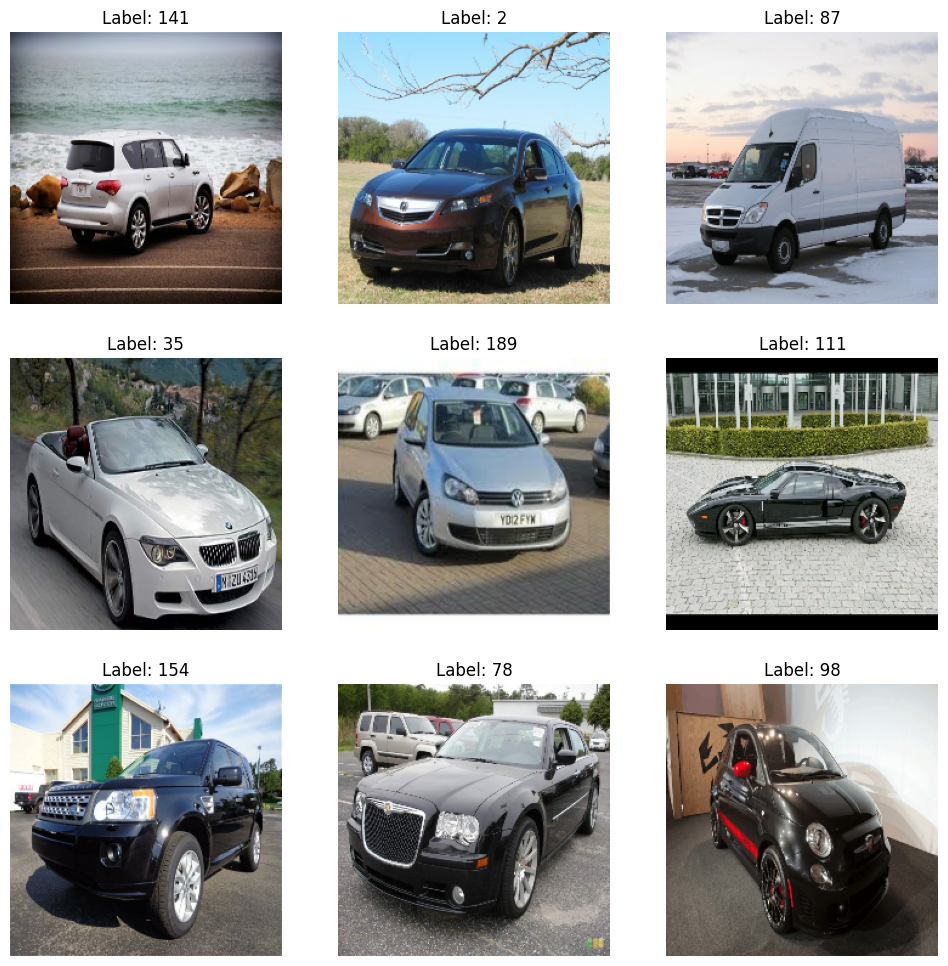

In [12]:
display_sample_images(test_images, test_labels, class_names)

# Create CNN:

* Feature Extraction (Convolutional + Pooling Layers)

    The CNN extracts patterns (edges, textures, shapes) from images using convolutional layers.

    Each Conv2D layer applies filters (kernels) to the input, detecting features like edges or textures.

    BatchNormalization helps stabilize training by normalizing activations.

    MaxPooling2D reduces spatial dimensions, keeping important information while reducing computation.

* Classification (Fully Connected Layers)

    The Flatten layer converts 2D feature maps into a 1D vector.

    A Dense (fully connected) layer with 256 neurons learns complex patterns from extracted features.

    Dropout (0.5) prevents overfitting by randomly deactivating 50% of neurons.

    The final Dense(NUM_CLASSES, activation='softmax') layer outputs probabilities for each class.


* Optimization & Training
    Loss Function: categorical_crossentropy (used for multi-class classification)

    Optimizer: Adam with a small learning rate (0.0001) to ensure smooth learning.

    Learning Rate Scheduler: ReduceLROnPlateau

    Reduces learning rate when validation loss stops improving, preventing overfitting.


## Overall process:
1. Takes an image of shape (IMG_HEIGHT, IMG_WIDTH, CHANNELS).

2. Extracts key features using convolutional layers.

3. Reduces dimensions and noise using pooling layers.

4. Learns complex patterns using fully connected layers.

5. Outputs class probabilities using softmax activation.

6. Trains using Adam optimizer and scheduled learning rate reduction.


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 30
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 224, 224, 3  # Adjust if needed
NUM_CLASSES = 196  # Update based on your dataset

# Define the model
# def create_cnn_model(input_shape=(224, 224, 3), num_classes=196):
#     model = models.Sequential()

#     # 1st Conv Block
#     model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Dropout(0.25))

#     # 2nd Conv Block
#     model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Dropout(0.25))

#     # 3rd Conv Block
#     model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Dropout(0.3))

#     # 4th Conv Block
#     model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Dropout(0.3))

#     # Flatten
#     model.add(layers.Flatten())

#     # Fully Connected Layers
#     model.add(layers.Dense(512, activation='relu'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(0.4))

#     model.add(layers.Dense(256, activation='relu'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.Dropout(0.4))

#     model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer for classification

#     # Compile the model
#     model.compile(optimizer='adam',
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

#     return model

# Create model
# model_cnn = create_cnn_model()

# Print model summary
# model_cnn.summary()

# Define improved CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 196)                 │          50,372 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,834,884 (98.55 MB)

 Trainable params: 25,834,436 (98.55 MB)

 Non-trainable params: 448 (1.75 KB)

# Load and prepare the data before running the model

In [23]:
BATCH_SIZE = 10

# Load and prepare dataset
train_dataset = tf.data.TFRecordDataset(train_tfrecords)
train_dataset = train_dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(10000).repeat().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.TFRecordDataset(test_tfrecords)
test_dataset = test_dataset.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # No shuffle

In [24]:
val_size = 0.2  # 20% of training data for validation
total_train_samples = 10000  # Replace with the actual number of training samples

val_samples = int(total_train_samples * val_size)

val_dataset = train_dataset.take(val_samples)  # First part for validation
train_dataset = train_dataset.skip(val_samples)  # Remaining for training

# Train the model

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 30  # Adjust as needed
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

STEPS_PER_EPOCH = total_train_samples // BATCH_SIZE  # Define steps per epoch

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, lr_scheduler],
    steps_per_epoch=500
)

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 76s 88ms/step - accuracy: 0.0093 - loss: 5.2877 - val_accuracy: 0.0125 - val_loss: 5.2477 - learning_rate: 1.0000e-04
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.0098 - loss: 5.2731 - val_accuracy: 0.0112 - val_loss: 5.2671 - learning_rate: 1.0000e-04
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.0095 - loss: 5.2853 - val_accuracy: 0.0153 - val_loss: 5.2340 - learning_rate: 1.0000e-04
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.0120 - loss: 5.2625 - val_accuracy: 0.0152 - val_loss: 5.2366 - learning_rate: 1.0000e-04
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.0120 - loss: 5.2478 - val_accuracy: 0.0165 - val_loss: 5.2209 - learning_rate: 1.0000e-04
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.0125 - loss: 5.2715 - val_accuracy: 0.0162 - val_loss: 5.2190 - learning_rate: 1.0000e-04
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/ste

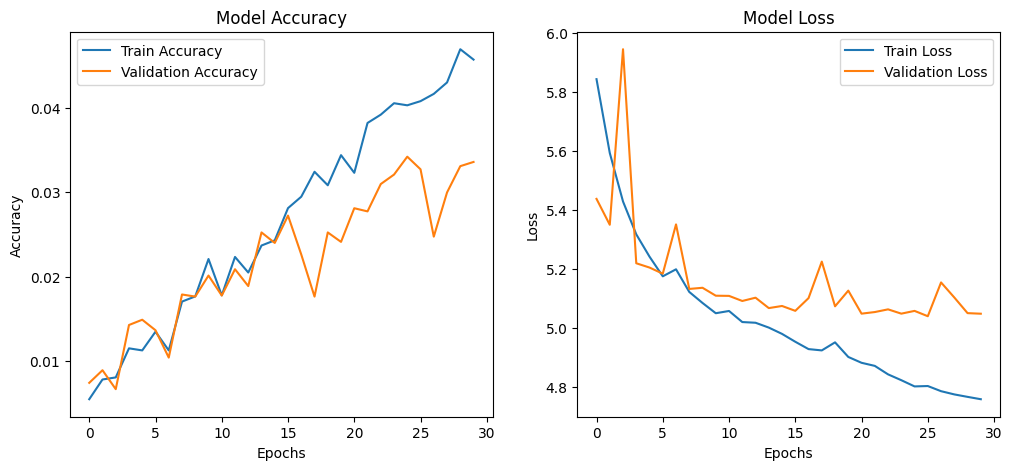

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')

    plt.show()

# Call the function after training
plot_training_history(history)

# Show Test predictions: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_sample_predictions(model, dataset, class_names, num_images=9):
    import random

    # Get a batch of test images and labels
    batch_images, batch_labels = next(iter(dataset))
    batch_predictions = model.predict(batch_images)

    # Convert one-hot labels to class indices
    batch_labels = np.argmax(batch_labels.numpy(), axis=1)
    batch_predictions = np.argmax(batch_predictions, axis=1)

    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        idx = random.randint(0, len(batch_images) - 1)
        plt.subplot(3, 3, i + 1)

        # Ensure the image is in uint8 format for proper display
        image = batch_images[idx].numpy()
        if image.max() <= 1.0:  # If image is normalized (0-1), convert it to (0-255)
            image = (image * 255).astype(np.uint8)

        plt.imshow(image)
        plt.title(f"Actual: {class_names[batch_labels[idx]]}\nPredicted: {class_names[batch_predictions[idx]]}")
        plt.axis("off")

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


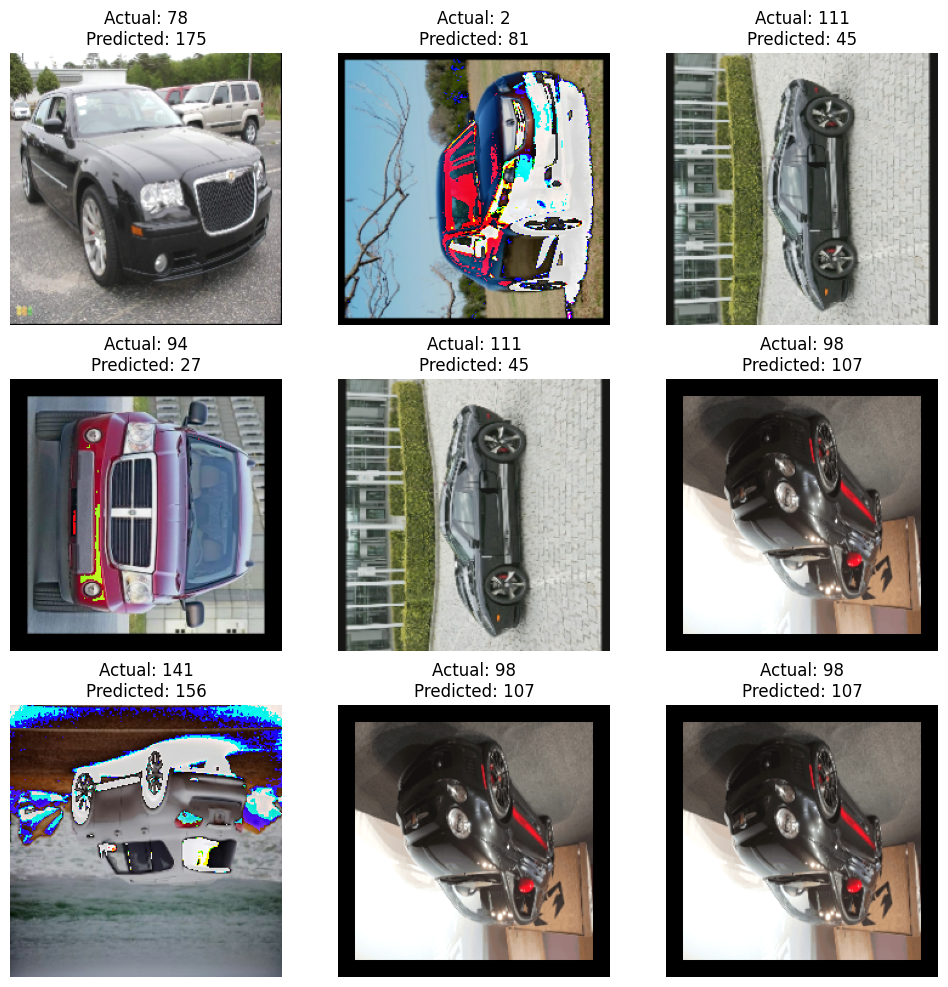

In [ ]:
class_names = [str(i) for i in range(196)]  # Modify based on your actual class labels
show_sample_predictions(model_cnn, test_dataset, class_names)

# Test model

In [28]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

805/805 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.0080 - loss: 5.2765
Test Accuracy: 0.0087
Test Loss: 5.2759


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
